In [1]:
import os
from glob import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn

import dask.dataframe as dd
from gprofiler import GProfiler

```
mermaid
graph TB
A1[all genomic variants] -->|step 1.1: filter<br>in reported genes| B(step 1.2: variant effect prediction)
    B --> C{step 1.3: Coding consequence}
    C -->|Yes| D[step 1.4: case-control association] 
    C -->|No| E[step 1.5: case-control association]
    D --> F{step 1.4.1<br>check <br>significance<br>raw p-value < 0.05} -->|YES|H(None)
    E --> G{step 1.5.1<br>check <br>significance<br>raw p-value < 0.01} -->|YES|I(13 intronic variants)
A1 -->B1(step 2.1: variant effect prediction)
B1 -->C1{step 2.2: Coding consequence} --> |YES| D1[step 2.3: case-control association] 
D1 -->|step 2.4: filter <br>alternate-allele <br>in cases only| F1{step 2.5: check <br>significance<br>raw p-value < 0.05} -->|YES|H3{step 2.6: raw p-value < 0.005} --> |YES|H1(varinats<br>on<br>11 genes)
F1 --> |YES|G1(step 2.7: Co-occurance) --> |"step 2.7.1: filter<br>alter-alleles-count<br>sum<br>in cases only &ge; 10"|I1(multi-variant genes)
H1 --> J1(Genes-of-Interest)
I1 --> J1
J1 --> F3

A3(PPIs-STRING-hs) --> B3(step 3.1: preprocess) 
B3 --> C3(step 3.2: normalize<br>combined_score)
C3 --> D3(step 3.3: plot distribution<br>combined_score<br>normalized_score<br>analyze)
D3 --> E3("step 3.4: filter<br>high-confidence PPIs:<br>combined_scode &gt; 800<br> or <br>normalized_score &gt; 0.8")
E3 --> F3(setp 3.5: select GOIs for subnetwork<br>with Cytoscape)
F3 --> G3(step 3.6: extend subnet: <br>also include <br>immideate neighbors of GOIs<br> with Cytoscape)
G3 --> I3(step 3.7: further extend subnet:<br> also include nodes with<br> two or more neighbors in selected nodes<br>with Cytoscape)
I3 --> J3(step 3.8: cluster subnet into <br> connected components <br> with Cytoscape)
J3 --> K3(setp 3.9: select genes <br>in largest compnent:<br>say extended-GOIs<br> with Cytoscape)
K3 --> L3(step 3.10: gProfile: functional enrichment analysis)
L3 --> M3(step 3.11: report hightly enriched<br> terms relevant to OUD) 
```

In [2]:
impact_dict = {'HIGH': 4, 'MODERATE': 3, 'LOW': 2, 'MODIFIER': 1}
impact_val2txt_dict = {v: f"{v}.{k}"for k, v in impact_dict.items()}

# Add a numeric value column mapping the IMPACTs to unique values allowing numeric sorting

In [3]:
ADD_NUMERIC_IMPACT = False
READ_NUMERIC_IMPACT = not ADD_NUMERIC_IMPACT

In [4]:
if ADD_NUMERIC_IMPACT:
    df_csq_imp = dd.read_csv("data/conseq-impacts.tsv", sep="\t", index_col=None)
    df_csq_imp['IMPACT_value'] = 0 # add a column to dataframe for impact_importance(int)
    for i, row in df_csq_imp.iterrows():
        df_csq_imp.loc[i, 'IMPACT_value'] = impact_dict[df_csq_imp.loc[i, 'IMPACT']] 
    df_csq_imp.to_csv("conseq-impact-level.tsv", sep="\t", index=None)
elif READ_NUMERIC_IMPACT:
    df_csq_imp = pd.read_csv("data/conseq-impact-level.tsv", sep="\t", index_col=None)

In [5]:
impact_val2txt_dict

{4: '4.HIGH', 3: '3.MODERATE', 2: '2.LOW', 1: '1.MODIFIER'}

In [6]:
df_csq_imp.head()

,SO term,SO description,SO accession,Display term,IMPACT,IMPACT_value
0,transcript_ablation,A feature ablation whereby the deleted region ...,SO:0001893,Transcript ablation,HIGH,4
1,splice_acceptor_variant,A splice variant that changes the 2 base regio...,SO:0001574,Splice acceptor variant,HIGH,4
2,splice_donor_variant,A splice variant that changes the 2 base regio...,SO:0001575,Splice donor variant,HIGH,4
3,stop_gained,A sequence variant whereby at least one base o...,SO:0001587,Stop gained,HIGH,4
4,frameshift_variant,A sequence variant which causes a disruption o...,SO:0001589,Frameshift variant,HIGH,4


# Load variants annotated with consequence, impact, and gene info extracted from VEP output

In [7]:
assoc_dir = "genome-wide-association"

In [8]:
df_var_imp = pd.read_csv(f"{assoc_dir}/annot_mscvo.txt", sep="\t", index_col=False)

In [9]:
df_var_imp.shape

(16393, 95)

In [10]:
sample_pheno_df = pd.read_csv("data/sample-phenotypes-plink.txt", sep=r"\s+", header=None)
sample_pheno_df = sample_pheno_df[[0, 2]]
sample_pheno_df.columns = ['sample_id', 'phenotype']
samples_list = sample_pheno_df['sample_id'].values

In [11]:
sample_cases_df = sample_pheno_df[sample_pheno_df['phenotype']==2]
sample_cntrl_df = sample_pheno_df[sample_pheno_df['phenotype']==1]

In [12]:
sample_cntrl_df

,sample_id,phenotype
1,EA_2_S2,1
2,EA_3_S3,1
6,EA_8_S7,1
7,EA_9_S8,1
10,EA_12_S11,1
11,EA_13_S12,1
18,EA_20_S19,1
19,EA_21_S20,1
20,EA_22_S21,1
21,EA_23_S22,1


In [13]:
# List human chromosomes
hs_chroms = ['chr'+str(i) for i in range(1, 23)] + ['chrX', 'chrY'] 
# hs_chroms

# Filter-in variants mapped to human chromosomes only discarding unknown chromosomes (errorneously)

In [14]:
df_var_imp_hs = df_var_imp[df_var_imp['#[1]CHROM'].isin(hs_chroms)]

In [15]:
df_var_imp_hs.shape

(16393, 95)

In [16]:
df_var_imp_hs.columns

Index(['#[1]CHROM', '[2]POS', '[3]ID', '[4]Consequence', '[5]Consequence',
       '[6]Consequence', '[7]Consequence', '[8]Consequence', '[9]Consequence',
       '[10]Consequence', '[11]Consequence', '[12]Consequence',
       '[13]Consequence', '[14]Consequence', '[15]Consequence',
       '[16]Consequence', '[17]Consequence', '[18]Consequence',
       '[19]Consequence', '[20]Consequence', '[21]Consequence',
       '[22]Consequence', '[23]Consequence', '[24]Consequence',
       '[25]Consequence', '[26]Consequence', '[27]IMPACT', '[28]IMPACT',
       '[29]IMPACT', '[30]IMPACT', '[31]IMPACT', '[32]IMPACT', '[33]IMPACT',
       '[34]IMPACT', '[35]IMPACT', '[36]IMPACT', '[37]IMPACT', '[38]IMPACT',
       '[39]IMPACT', '[40]IMPACT', '[41]IMPACT', '[42]IMPACT', '[43]IMPACT',
       '[44]IMPACT', '[45]IMPACT', '[46]IMPACT', '[47]IMPACT', '[48]IMPACT',
       '[49]IMPACT', '[50]Gene', '[51]Gene', '[52]Gene', '[53]Gene',
       '[54]Gene', '[55]Gene', '[56]Gene', '[57]Gene', '[58]Gene', '[59]Gene

In [17]:
df_var_imp_hs_new_colnames = ['CHROM', 'POS', 'ID']
df_var_imp_hs_new_colnames += [f"CSQ.{s}" for s in samples_list]
df_var_imp_hs_new_colnames += [f"IMP.{s}" for s in samples_list]
df_var_imp_hs_new_colnames += [f"Gene.{s}" for s in samples_list]
df_var_imp_hs_new_colnames += [f"GT.{s}" for s in samples_list]

In [18]:
print(len(df_var_imp_hs_new_colnames), df_var_imp_hs.shape[1])
len(df_var_imp_hs_new_colnames) == df_var_imp_hs.shape[1]

df_var_imp_hs.columns = df_var_imp_hs_new_colnames

95 95


In [19]:
conseq_cols = [c for c in df_var_imp_hs.columns if c.startswith("CSQ.")]
impact_cols = [c for c in df_var_imp_hs.columns if c.startswith("IMP.")]
genes_cols = [c for c in df_var_imp_hs.columns if c.startswith("Gene.") or c.endswith("Gene") and c != 'Gene_cons']
allele_cols = [c for c in df_var_imp_hs.columns if c.startswith("GT.") or c.endswith("Allele")]

In [20]:
df_var_imp_hs_cons = df_var_imp_hs
genes_cols

['Gene.EA_1_S1',
 'Gene.EA_2_S2',
 'Gene.EA_3_S3',
 'Gene.EA_4_S4',
 'Gene.EA_6_S5',
 'Gene.EA_7_S6',
 'Gene.EA_8_S7',
 'Gene.EA_9_S8',
 'Gene.EA_10_S9',
 'Gene.EA_11_S10',
 'Gene.EA_12_S11',
 'Gene.EA_13_S12',
 'Gene.EA_14_S13',
 'Gene.EA_15_S14',
 'Gene.EA_16_S15',
 'Gene.EA_17_S16',
 'Gene.EA_18_S17',
 'Gene.EA_19_S18',
 'Gene.EA_20_S19',
 'Gene.EA_21_S20',
 'Gene.EA_22_S21',
 'Gene.EA_23_S22',
 'Gene.EA_24_S23']

# Find the consensus consequence, impact and genes among all the samples and then reduce to highest severity impact annotated for the variant

In [21]:
alleles_cases_cols = [f"GT.{s}" for s in sample_cases_df['sample_id'].values]

In [22]:
alleles_cntrl_cols = [f"GT.{s}" for s in sample_cntrl_df['sample_id'].values]

In [23]:
print(len(alleles_cases_cols), alleles_cases_cols)

12 ['GT.EA_1_S1', 'GT.EA_4_S4', 'GT.EA_6_S5', 'GT.EA_7_S6', 'GT.EA_10_S9', 'GT.EA_11_S10', 'GT.EA_14_S13', 'GT.EA_15_S14', 'GT.EA_16_S15', 'GT.EA_17_S16', 'GT.EA_18_S17', 'GT.EA_19_S18']


In [24]:
print(len(alleles_cntrl_cols), alleles_cntrl_cols, )

11 ['GT.EA_2_S2', 'GT.EA_3_S3', 'GT.EA_8_S7', 'GT.EA_9_S8', 'GT.EA_12_S11', 'GT.EA_13_S12', 'GT.EA_20_S19', 'GT.EA_21_S20', 'GT.EA_22_S21', 'GT.EA_23_S22', 'GT.EA_24_S23']


## Find the consensus consequence for the variant across all the samples, gene harboring the variant. and Genotypes for all the cases and control samples

In [25]:
df_var_imp_hs_cons['Consequence_cons'] = ''
df_var_imp_hs_cons['IMPACT_cons'] = ''
df_var_imp_hs_cons['Gene_cons'] = ''
df_var_imp_hs_cons['GT_cases'] = ''
df_var_imp_hs_cons['GT_cntrl'] = ''

In [26]:
for i, row in df_var_imp_hs_cons.iterrows():
    uniq_imps, uniq_impx = np.unique(row[impact_cols], return_index=True)
    uniq_csqs, uniq_csqx = np.unique(row[conseq_cols], return_index=True)
    uniq_gens, uniq_genx = np.unique(row[genes_cols], return_index=True)
    uniq_case = np.unique(row[alleles_cases_cols])
    uniq_case_samples = {}
    for unqcs in alleles_cases_cols:
        unqcsal = row[unqcs]
        if len(unqcsal)>4:
            unqcsal = unqcsal[:4]+"---"
        if unqcsal not in uniq_case_samples:
            uniq_case_samples[unqcsal] = [unqcs[unqcs.rindex("_")+1:],]
        elif unqcsal in uniq_case_samples:
            uniq_case_samples[unqcsal].append(unqcs[unqcs.rindex("_")+1:])
    df_var_imp_hs_cons.loc[i, 'GT_cases'] = "; ".join([k+"["+"+".join(v)+"]" for k, v in uniq_case_samples.items()])
    if row['POS']==69849:
        print("uniq_case_samples=", uniq_case_samples, "uniq_case=",uniq_case, "=>", row[alleles_cases_cols])
        print("joined_cases: ", "; ".join([k+"["+"|".join(v)+"]" for k, v in uniq_case_samples.items()]))
       
       
    uniq_cntrl = np.unique(row[alleles_cntrl_cols])
    uniq_cntrl_samples = {}
    for unqcs in alleles_cntrl_cols:
        unqcsal = row[unqcs]
        if len(unqcsal)>4:
            unqcsal = unqcsal[:4]+"---"
        if unqcsal not in uniq_cntrl_samples:
            uniq_cntrl_samples[unqcsal] = [unqcs[unqcs.rindex("_")+1:],]
        elif unqcsal in uniq_cntrl_samples:
            uniq_cntrl_samples[unqcsal].append(unqcs[unqcs.rindex("_")+1:])
    df_var_imp_hs_cons.loc[i, 'GT_cntrl'] = "; ".join([k+"["+"+".join(v)+"]" for k, v in uniq_cntrl_samples.items()])
    if row['POS']==69849:
        print("uniq_cntrl_samples=", uniq_cntrl_samples, "uniq_cntrl=",uniq_cntrl, "=>", row[alleles_cntrl_cols])
        print("joined_cntrl: ", "; ".join([k+"["+"|".join(v)+"]" for k, v in uniq_cntrl_samples.items()]))
       
    # try:
    impact_vals = np.array([(impact_dict[k1], uniq_impx[ui]) for ui, uv in enumerate(uniq_imps) for k1 in uv.split(",")])
    max_idx = np.argmax(uniq_imps)
    max_val = impact_vals[max_idx]
    conseq_high = uniq_csqs[max_val[1]].split(",")[max_idx]
    gene_high = uniq_gens[max_val[1]].split(",")[max_idx]

    df_var_imp_hs_cons.loc[i, 'Consequence_cons'] = conseq_high
    df_var_imp_hs_cons.loc[i, 'Gene_cons'] = gene_high
    df_var_imp_hs_cons.loc[i, 'IMPACT_cons'] = impact_val2txt_dict[max_val[0]]
    # except:
    #     print(uniq_imps, uniq_impx)
    #     print(">>", impact_vals, "<<<",  max_val, max_idx, ">>>")
    #     print(">>", uniq_csqs, "<<<",  conseq_high, ">>>")
    #     print("="*80)

In [27]:
df_var_imp_hs_cons.head()

,CHROM,POS,ID,CSQ.EA_1_S1,CSQ.EA_2_S2,CSQ.EA_3_S3,CSQ.EA_4_S4,CSQ.EA_6_S5,CSQ.EA_7_S6,CSQ.EA_8_S7,...,GT.EA_20_S19,GT.EA_21_S20,GT.EA_22_S21,GT.EA_23_S22,GT.EA_24_S23,Consequence_cons,IMPACT_cons,Gene_cons,GT_cases,GT_cntrl
0,chr1,69511,.,missense_variant,missense_variant,missense_variant,missense_variant,missense_variant,missense_variant,missense_variant,...,1/1,./.,./.,1/1,0/0,missense_variant,3.MODERATE,ENSG00000186092,1/1[S1+S4+S5+S6+S9+S10+S14+S15+S16+S17]; ./.[S...,./.[S2+S8+S20+S21]; 1/1[S3+S7+S12+S19+S22]; 0/...
1,chr1,168098,.,splice_donor_variant&non_coding_transcript_var...,splice_donor_variant&non_coding_transcript_var...,splice_donor_variant&non_coding_transcript_var...,splice_donor_variant&non_coding_transcript_var...,splice_donor_variant&non_coding_transcript_var...,splice_donor_variant&non_coding_transcript_var...,splice_donor_variant&non_coding_transcript_var...,...,0/0,0/1,0/0,0/0,0/0,splice_donor_variant&non_coding_transcript_var...,4.HIGH,ENSG00000241860,0/0[S1+S4+S6+S9+S10+S13+S14+S15+S16+S17+S18]; ...,0/0[S2+S7+S11+S12+S19+S21+S22+S23]; 0/1[S3+S20...
2,chr1,976215,.,missense_variant,missense_variant,missense_variant,missense_variant,missense_variant,missense_variant,missense_variant,...,1/1,1/1,0/1,1/1,1/1,missense_variant,3.MODERATE,ENSG00000187642,0/1[S1+S6+S14+S17]; 1/1[S4+S5+S9+S10+S13+S15+S...,0/1[S2+S7+S21]; 1/1[S3+S11+S12+S19+S20+S22+S23...
3,chr1,978953,.,missense_variant,missense_variant,missense_variant,missense_variant,missense_variant,missense_variant,missense_variant,...,1/1,1/1,0/1,1/1,0/1,missense_variant,3.MODERATE,ENSG00000187642,0/1[S1+S5+S13+S14+S18]; 1/1[S4+S9+S10+S15+S16]...,0/1[S2+S7+S11+S12+S21+S23]; 1/1[S3+S19+S20+S22...
4,chr1,979459,.,missense_variant,missense_variant,missense_variant,missense_variant,missense_variant,missense_variant,missense_variant,...,0/1,0/0,0/1,0/0,0/0,missense_variant,3.MODERATE,ENSG00000187642,0/0[S1+S4+S5+S6+S9+S10+S13+S14+S15+S17]; 0/1[S...,0/1[S2+S19+S21]; 0/0[S3+S7+S11+S12+S20+S22+S23...


In [28]:
df_var_imp_hs_cons.columns

Index(['CHROM', 'POS', 'ID', 'CSQ.EA_1_S1', 'CSQ.EA_2_S2', 'CSQ.EA_3_S3',
       'CSQ.EA_4_S4', 'CSQ.EA_6_S5', 'CSQ.EA_7_S6', 'CSQ.EA_8_S7',
       'CSQ.EA_9_S8', 'CSQ.EA_10_S9', 'CSQ.EA_11_S10', 'CSQ.EA_12_S11',
       'CSQ.EA_13_S12', 'CSQ.EA_14_S13', 'CSQ.EA_15_S14', 'CSQ.EA_16_S15',
       'CSQ.EA_17_S16', 'CSQ.EA_18_S17', 'CSQ.EA_19_S18', 'CSQ.EA_20_S19',
       'CSQ.EA_21_S20', 'CSQ.EA_22_S21', 'CSQ.EA_23_S22', 'CSQ.EA_24_S23',
       'IMP.EA_1_S1', 'IMP.EA_2_S2', 'IMP.EA_3_S3', 'IMP.EA_4_S4',
       'IMP.EA_6_S5', 'IMP.EA_7_S6', 'IMP.EA_8_S7', 'IMP.EA_9_S8',
       'IMP.EA_10_S9', 'IMP.EA_11_S10', 'IMP.EA_12_S11', 'IMP.EA_13_S12',
       'IMP.EA_14_S13', 'IMP.EA_15_S14', 'IMP.EA_16_S15', 'IMP.EA_17_S16',
       'IMP.EA_18_S17', 'IMP.EA_19_S18', 'IMP.EA_20_S19', 'IMP.EA_21_S20',
       'IMP.EA_22_S21', 'IMP.EA_23_S22', 'IMP.EA_24_S23', 'Gene.EA_1_S1',
       'Gene.EA_2_S2', 'Gene.EA_3_S3', 'Gene.EA_4_S4', 'Gene.EA_6_S5',
       'Gene.EA_7_S6', 'Gene.EA_8_S7', 'Gene.EA_9_S8', 'Gen

In [29]:
df_var_imp_hs_cons.to_csv(f"{assoc_dir}/annot-vars-imp-unify.tsv", sep="\t", index=None)

In [30]:
df_var_imp_hs_cons_only = df_var_imp_hs_cons.drop(columns=impact_cols)
df_var_imp_hs_cons_only = df_var_imp_hs_cons_only.drop(columns=conseq_cols)
df_var_imp_hs_cons_only = df_var_imp_hs_cons_only.drop(columns=genes_cols)
df_var_imp_hs_cons_only = df_var_imp_hs_cons_only.drop(columns=allele_cols)

In [31]:
df_var_imp_hs_cons_only.to_csv(f"{assoc_dir}/annot-vars-imp-unify-only.tsv", sep="\t", index=None)

In [32]:
df_var_imp_hs_cons_only

,CHROM,POS,ID,Consequence_cons,IMPACT_cons,Gene_cons,GT_cases,GT_cntrl
0,chr1,69511,.,missense_variant,3.MODERATE,ENSG00000186092,1/1[S1+S4+S5+S6+S9+S10+S14+S15+S16+S17]; ./.[S...,./.[S2+S8+S20+S21]; 1/1[S3+S7+S12+S19+S22]; 0/...
1,chr1,168098,.,splice_donor_variant&non_coding_transcript_var...,4.HIGH,ENSG00000241860,0/0[S1+S4+S6+S9+S10+S13+S14+S15+S16+S17+S18]; ...,0/0[S2+S7+S11+S12+S19+S21+S22+S23]; 0/1[S3+S20...
2,chr1,976215,.,missense_variant,3.MODERATE,ENSG00000187642,0/1[S1+S6+S14+S17]; 1/1[S4+S5+S9+S10+S13+S15+S...,0/1[S2+S7+S21]; 1/1[S3+S11+S12+S19+S20+S22+S23...
3,chr1,978953,.,missense_variant,3.MODERATE,ENSG00000187642,0/1[S1+S5+S13+S14+S18]; 1/1[S4+S9+S10+S15+S16]...,0/1[S2+S7+S11+S12+S21+S23]; 1/1[S3+S19+S20+S22...
4,chr1,979459,.,missense_variant,3.MODERATE,ENSG00000187642,0/0[S1+S4+S5+S6+S9+S10+S13+S14+S15+S17]; 0/1[S...,0/1[S2+S19+S21]; 0/0[S3+S7+S11+S12+S20+S22+S23...
...,...,...,...,...,...,...,...,...
16388,chrY,14840900,.,stop_gained&protein_altering_variant,4.HIGH,ENSG00000165246,./.[S1+S4+S5+S6+S9+S15+S16+S18]; 0/0[S10+S13+S...,./.[S2+S3+S7+S8+S12+S20+S22]; 0/0[S11+S19+S21+...
16389,chrY,14840902,.,frameshift_variant,4.HIGH,ENSG00000165246,./.[S1+S4+S5+S6+S9+S15+S16+S18]; 0/0[S10+S13+S...,./.[S2+S3+S7+S8+S12+S20+S22]; 0/0[S11+S19+S21+...
16390,chrY,19715951,.,stop_gained&inframe_insertion,4.HIGH,ENSG00000012817,./.[S1+S4+S5+S6+S9+S15+S16+S17+S18]; 0/0[S10+S...,./.[S2+S3+S7+S8+S12+S20+S22]; 0/0[S11+S21+S23]...
16391,chrY,19732711,.,missense_variant,3.MODERATE,ENSG00000012817,./.[S1+S4+S5+S6+S9+S15+S16+S17+S18]; 0/0[S10+S...,./.[S2+S3+S7+S8+S12+S20+S22]; 1/1[S11]; 0/0[S1...


In [33]:
assoc_reports = [
    f"combined.jc.vep_mscvo.qc_assoc-count.assoc",
]

In [34]:
df_var_imp_hs_cons_only

,CHROM,POS,ID,Consequence_cons,IMPACT_cons,Gene_cons,GT_cases,GT_cntrl
0,chr1,69511,.,missense_variant,3.MODERATE,ENSG00000186092,1/1[S1+S4+S5+S6+S9+S10+S14+S15+S16+S17]; ./.[S...,./.[S2+S8+S20+S21]; 1/1[S3+S7+S12+S19+S22]; 0/...
1,chr1,168098,.,splice_donor_variant&non_coding_transcript_var...,4.HIGH,ENSG00000241860,0/0[S1+S4+S6+S9+S10+S13+S14+S15+S16+S17+S18]; ...,0/0[S2+S7+S11+S12+S19+S21+S22+S23]; 0/1[S3+S20...
2,chr1,976215,.,missense_variant,3.MODERATE,ENSG00000187642,0/1[S1+S6+S14+S17]; 1/1[S4+S5+S9+S10+S13+S15+S...,0/1[S2+S7+S21]; 1/1[S3+S11+S12+S19+S20+S22+S23...
3,chr1,978953,.,missense_variant,3.MODERATE,ENSG00000187642,0/1[S1+S5+S13+S14+S18]; 1/1[S4+S9+S10+S15+S16]...,0/1[S2+S7+S11+S12+S21+S23]; 1/1[S3+S19+S20+S22...
4,chr1,979459,.,missense_variant,3.MODERATE,ENSG00000187642,0/0[S1+S4+S5+S6+S9+S10+S13+S14+S15+S17]; 0/1[S...,0/1[S2+S19+S21]; 0/0[S3+S7+S11+S12+S20+S22+S23...
...,...,...,...,...,...,...,...,...
16388,chrY,14840900,.,stop_gained&protein_altering_variant,4.HIGH,ENSG00000165246,./.[S1+S4+S5+S6+S9+S15+S16+S18]; 0/0[S10+S13+S...,./.[S2+S3+S7+S8+S12+S20+S22]; 0/0[S11+S19+S21+...
16389,chrY,14840902,.,frameshift_variant,4.HIGH,ENSG00000165246,./.[S1+S4+S5+S6+S9+S15+S16+S18]; 0/0[S10+S13+S...,./.[S2+S3+S7+S8+S12+S20+S22]; 0/0[S11+S19+S21+...
16390,chrY,19715951,.,stop_gained&inframe_insertion,4.HIGH,ENSG00000012817,./.[S1+S4+S5+S6+S9+S15+S16+S17+S18]; 0/0[S10+S...,./.[S2+S3+S7+S8+S12+S20+S22]; 0/0[S11+S21+S23]...
16391,chrY,19732711,.,missense_variant,3.MODERATE,ENSG00000012817,./.[S1+S4+S5+S6+S9+S15+S16+S17+S18]; 0/0[S10+S...,./.[S2+S3+S7+S8+S12+S20+S22]; 1/1[S11]; 0/0[S1...


## Step 2.4 and 2.5: Filter-in only variants with raw p-value < 0.05 for association to phenotype

In [35]:
pvalue_threshold = 0.05
for rpt in assoc_reports:
    df_rpt = pd.read_csv(assoc_dir + '/'+rpt, sep="\s+", index_col=None)
    df_rpt['CHR'] = ['chr' + str(c) for c in df_rpt['CHR'].values]
    df_rpt_join = df_rpt.merge(df_var_imp_hs_cons_only, how="inner", left_on=['CHR', 'BP'], right_on=['CHROM', 'POS'])
    df_rpt_join = df_rpt_join.drop(columns=['CHROM', 'POS'])
    df_rpt_join.to_csv(assoc_dir + "/annot-gene-" + rpt + ".tsv", sep="\t", index=None)
    
    filter_rdf = df_rpt_join[(df_rpt_join['C_U']==0) & (df_rpt_join['P'] <= pvalue_threshold)]
    filter_rdf_sorted = filter_rdf.sort_values(by='P')
    filter_rdf_sorted.to_csv(f"{assoc_dir}/annot-var-impact-aggr-by-gene-p-value-lt-{pvalue_threshold:0.03f}.tsv", sep="\t", index=None)

In [36]:
filter_rdf_sorted.shape

(156, 16)

In [37]:
def highest_conseq(conseqs):
    cnsq_sort = sorted(conseqs, reverse=True)
    return cnsq_sort[0]

In [38]:
highest_conseq(['4.LOW', '3.MODERATE', '4.HIGH'])

'4.LOW'

In [39]:
def CA_list(ca):
    return '+'.join([i for i in ca])

In [40]:
def sample_alleles(allele_list):
    case_alleles_summary = " & ".join(allele_list)
    return case_alleles_summary

def sample_alleles_uniq(allele_list):
    allele_all_vars = []
    for alv in allele_list:
        allele_all_vars.extend(alv.split(";"))
    all_vars = {}
    for alv in allele_all_vars:
        aln = alv[0:alv.index("[")]
        smp = alv[alv.index("[")+1:alv.index("]")].split("+")
        if aln not in all_vars:
            all_vars[aln] = smp
        else:
            all_vars[aln].extend(smp)
    case_alleles_summary = " & ".join([k+"["+ "+".join(np.unique(v)) +"]" for k, v in all_vars.items()])
    return case_alleles_summary

def sample_alleles_counts(allele_list):
    allele_all_vars = []
    for alv in allele_list:
        allele_all_this = alv.split(";")
        all_vars = {}
        for alv in allele_all_this:
            aln = alv[0:alv.index("[")]
            smp = alv[alv.index("[")+1:alv.index("]")].split("+")
            if aln not in all_vars:
                all_vars[aln] = smp
            else:
                all_vars[aln].extend(smp)
        allele_all_vars.append(",".join([f"{k}[{len(v)}]" for k, v in all_vars.items()]))
    case_alleles_summary_count = " & ".join(allele_all_vars)
    return case_alleles_summary_count

def sample_alleles_counts_uniq(allele_list):
    allele_all_vars = []
    for alv in allele_list:
        allele_all_vars.extend(alv.split(";"))
    all_vars = {}
    for alv in allele_all_vars:
        aln = alv[0:alv.index("[")]
        smp = alv[alv.index("[")+1:alv.index("]")].split("+")
        if aln not in all_vars:
            all_vars[aln] = smp
        else:
            all_vars[aln].extend(smp)
    case_alleles_summary_count = " & ".join([f"{k}[{len(np.unique(v))}]" for k, v in all_vars.items()])
    return case_alleles_summary_count

In [41]:
filter_rdf_sorted_agg = filter_rdf_sorted.groupby(['Gene_cons']).agg({
    'Gene_cons': ['count'],
    'CHR': ['first'],
    'C_A': ['sum', lambda x: '+'.join([str(i) for i in x])],
    'C_U': 'sum', 
    'Consequence_cons': lambda x: '; '.join(x),
    'IMPACT_cons': lambda x: '; '.join(x),
    'GT_cases': [sample_alleles_counts, sample_alleles_counts_uniq, sample_alleles],
    'GT_cntrl': [sample_alleles_counts, sample_alleles]
}).reset_index()
filter_rdf_sorted_agg.columns = ['Gene', 'nVariants', 'CHROM', 'C_A_sum', 'C_A_list', 'C_U_sum', 'Consequence_cons_list', 'IMPACT_cons(higest)', 
                                 'nGT_cases', 'nGT_cases_uniq', 'GT_cases', 'nGT_controls', 'GT_controls']

In [42]:
filter_rdf_sorted_agg.to_csv(f"{assoc_dir}/annot-var-impact-aggr-by-gene-weighted-p-value-lt-{pvalue_threshold}.tsv", sep="\t", index=None)

In [43]:
filter_rdf_sorted_agg

,Gene,nVariants,CHROM,C_A_sum,C_A_list,C_U_sum,Consequence_cons_list,IMPACT_cons(higest),nGT_cases,nGT_cases_uniq,GT_cases,nGT_controls,GT_controls
0,ENSG00000000938,1,chr1,5,5,0,frameshift_variant,4.HIGH,"0/0[11], 0|1[1]",0/0[11] & 0|1[1],0/0[S1+S4+S5+S6+S10+S13+S14+S15+S16+S17+S18]; ...,"0/0[8], 0|1[2], 1|1[1]",0/0[S2+S3+S11+S12+S19+S20+S22+S23]; 0|1[S7+S21...
1,ENSG00000003989,1,chr8,4,4,0,missense_variant,3.MODERATE,"0/0[11], 0/1[1]",0/0[11] & 0/1[1],0/0[S1+S4+S6+S9+S10+S13+S14+S15+S16+S17+S18]; ...,"0/1[3], 0/0[8]",0/1[S2+S20+S21]; 0/0[S3+S7+S8+S11+S12+S19+S22+...
2,ENSG00000007944,1,chr6,4,4,0,missense_variant,3.MODERATE,"0/0[11], 0/1[1]",0/0[11] & 0/1[1],0/0[S1+S4+S5+S9+S10+S13+S14+S15+S16+S17+S18]; ...,"0/0[8], ./.[1], 1/1[1], 0/1[1]",0/0[S2+S3+S7+S11+S12+S21+S22+S23]; ./.[S8]; 1/...
3,ENSG00000011028,2,chr17,8,4+4,0,frameshift_variant; frameshift_variant,4.HIGH; 4.HIGH,"0/0[11], 0|1[1] & 0/0[11], 0|1[1]",0/0[11] & 0|1[1],0/0[S1+S4+S5+S6+S10+S13+S14+S15+S16+S17+S18]; ...,"0/0[9], 1|1[1], 0|1[1] & 0/0[9], 1|1[1], 0|1[1]",0/0[S2+S3+S7+S11+S12+S19+S21+S22+S23]; 1|1[S8]...
4,ENSG00000047578,1,chr16,4,4,0,missense_variant,3.MODERATE,0/0[12],0/0[12],0/0[S1+S4+S5+S6+S9+S10+S13+S14+S15+S16+S17+S18],"0/0[8], 1/1[1], 0/1[2]",0/0[S2+S3+S8+S11+S12+S20+S22+S23]; 1/1[S7]; 0/...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
121,ENSG00000249647,1,chr5,4,4,0,splice_donor_variant&non_coding_transcript_var...,4.HIGH,"0/0[11], 0|1[1]",0/0[11] & 0|1[1],0/0[S1+S4+S5+S6+S10+S13+S14+S15+S16+S17+S18]; ...,"0/1[2], 0/0[7], ./.[1], 0|1[1]",0/1[S2+S7]; 0/0[S3+S12+S19+S20+S21+S22+S23]; ....
122,ENSG00000254245,1,chr5,5,5,0,missense_variant,3.MODERATE,"0/0[10], 0/1[2]",0/0[10] & 0/1[2],0/0[S1+S4+S6+S9+S13+S14+S15+S16+S17+S18]; 0/1[...,"0/0[7], 0/1[3], ./.[1]",0/0[S2+S3+S12+S19+S20+S22+S23]; 0/1[S7+S11+S21...
123,ENSG00000261701,1,chr16,5,5,0,missense_variant,3.MODERATE,"0/1[2], 0/0[10]",0/1[2] & 0/0[10],0/1[S1+S6]; 0/0[S4+S5+S9+S10+S13+S14+S15+S16+S...,"0/0[7], 0/1[3], ./.[1]",0/0[S2+S3+S11+S12+S21+S22+S23]; 0/1[S7+S19+S20...
124,ENSG00000263870,1,chr17,5,5,0,splice_acceptor_variant&non_coding_transcript_...,4.HIGH,"0/0[11], 0/1[1]",0/0[11] & 0/1[1],0/0[S1+S4+S5+S9+S10+S13+S14+S15+S16+S17+S18]; ...,"0/0[7], 0|1[2], 1|1[1], 0|0[1]",0/0[S2+S3+S11+S12+S20+S22+S23]; 0|1[S7+S19]; 1...


In [44]:
gp = GProfiler(return_dataframe=True)

In [45]:
gene_list = list(filter_rdf_sorted_agg['Gene'].unique())

### Fetch gene names from gene_ids and save

In [46]:
fetch_gene_id_to_ensp_id_name = False

In [47]:
if fetch_gene_id_to_ensp_id_name:
    gene_id_to_name = gp.convert(organism='hsapiens', query=gene_list, target_namespace='ENSP')
    gene_id_to_ensp_id = gene_id_to_name.copy()
    gene_id_to_name = gene_id_to_name.drop(columns=['converted', 'n_incoming', 'n_converted', 'query'])
    gene_id_to_name_uniq = gene_id_to_name.drop_duplicates()

    gene_id_to_name_uniq.to_csv(f"{assoc_dir}/ENSG-to-proteinname-hsapiens_mssvo-pvalue-le-0.05-9-26-2024_11-18-05-AM-uniq.csv", index=False)
    gene_id_to_ensp_id.to_csv(f"{assoc_dir}/ENSG-to-ENSP-proteinname-hsapiens_mssvo-pvalue-le-0.05-9-26-2024_11-18-05-AM.csv", index=False)
    gene_id_to_name_uniq

In [48]:
if not fetch_gene_id_to_ensp_id_name:
    df_gene = pd.read_csv(f"{assoc_dir}/ENSG-to-proteinname-hsapiens_mssvo-pvalue-le-0.05-9-26-2024_11-18-05-AM-uniq.csv",  skiprows=0)
    df_gene.head()

### Variants effect summanry file has only GENE_IDs, lets add the gene_names info 

In [49]:
df_join_gn_names_variants = filter_rdf_sorted.merge(df_gene, how="inner", right_on=['incoming'], left_on=['Gene_cons'])
df_join_gn_names = filter_rdf_sorted_agg.merge(df_gene, how="inner", right_on=['incoming'], left_on=['Gene'])
print("df_join_gn_names_variants.shape=", df_join_gn_names_variants.shape,"df_join_gn_names.shape=", df_join_gn_names.shape)

df_join_gn_names_variants.shape= (156, 20) df_join_gn_names.shape= (126, 17)


In [50]:
print("df_join_gn_names_variants.columns=", df_join_gn_names_variants.columns)
print("filter_rdf_sorted.columns=", df_join_gn_names_variants.columns)
print(assoc_dir)

df_join_gn_names_variants1 = df_join_gn_names_variants.copy()
df_join_gn_names_variants = df_join_gn_names_variants1[['incoming', 'name', 
        'CHR', 'SNP', 'BP', 'A1', 'C_A', 'C_U', 'A2', 'CHISQ', 'P', 'OR', 'ID',
       'Consequence_cons', 'IMPACT_cons', 'Gene_cons', 'GT_cases', 'GT_cntrl']]

df_join_gn_names_variants.columns= Index(['CHR', 'SNP', 'BP', 'A1', 'C_A', 'C_U', 'A2', 'CHISQ', 'P', 'OR', 'ID',
       'Consequence_cons', 'IMPACT_cons', 'Gene_cons', 'GT_cases', 'GT_cntrl',
       'incoming', 'name', 'description', 'namespaces'],
      dtype='object')
filter_rdf_sorted.columns= Index(['CHR', 'SNP', 'BP', 'A1', 'C_A', 'C_U', 'A2', 'CHISQ', 'P', 'OR', 'ID',
       'Consequence_cons', 'IMPACT_cons', 'Gene_cons', 'GT_cases', 'GT_cntrl',
       'incoming', 'name', 'description', 'namespaces'],
      dtype='object')
genome-wide-association


In [51]:
df_join_gn_names_variants.head()

df_join_gn_names_variants.shape

(156, 18)

In [52]:
df_join_gn_names_variants.to_csv(f"{assoc_dir}/annot-var-impact-named-gene-p-value-lt-{pvalue_threshold}.tsv", sep="\t", index=None)

In [53]:
df_join_gn_names.to_csv(f"{assoc_dir}/annot-var-impact-aggr-by-gene-weighted-with-genename-p-value-lt-{pvalue_threshold}.tsv", sep="\t", index=None)

In [54]:
gene_uni_variant_signify = df_join_gn_names_variants[df_join_gn_names_variants['P'] <= 0.005].sort_values(by=['P'], ascending=True)

In [55]:
#gene_uni_variant_signify.columns = [ 'nVarinats']
gene_uni_variant_signify = gene_uni_variant_signify.reset_index()

In [56]:
gene_uni_variant_signify = gene_uni_variant_signify.drop(columns=['index'])

In [57]:
gene_uni_variant_signify

,incoming,name,CHR,SNP,BP,A1,C_A,C_U,A2,CHISQ,P,OR,ID,Consequence_cons,IMPACT_cons,Gene_cons,GT_cases,GT_cntrl
0,ENSG00000185958,FAM186A,chr12,.,50352078,TGA,11,0,T,13.250,0.000272,NaN,.,frameshift_variant,4.HIGH,ENSG00000185958,0/0[S1+S4+S6+S13+S14+S15+S16+S17+S18]; 1|1[S5+...,0/0[S2+S3+S8+S11+S12+S19+S22+S23]; 1|1[S7+S20]...
1,ENSG00000175356,SCUBE2,chr11,.,9091455,G,10,0,A,12.940,0.000321,NaN,.,missense_variant,3.MODERATE,ENSG00000175356,0/1[S1+S5+S6+S10]; 0/0[S4+S9+S13+S14+S15+S16+S...,0/1[S2+S11+S19+S20]; 0/0[S3+S7+S12+S22+S23]; ....
2,ENSG00000178395,CCDC185,chr1,.,223394461,A,9,0,G,11.310,0.000769,NaN,.,missense_variant,3.MODERATE,ENSG00000178395,0/1[S1+S9+S10]; 0/0[S4+S5+S13+S14+S15+S16+S17+...,0/0[S2+S3+S7+S11+S12+S22+S23]; ./.[S8]; 0/1[S1...
3,ENSG00000132938,MTUS2,chr13,.,29324631,A,8,0,C,9.778,0.001766,NaN,.,missense_variant,3.MODERATE,ENSG00000132938,0/1[S1+S9+S10]; 1/1[S4+S5+S6+S13+S14+S15+S16+S...,0/1[S2+S7+S20]; 1/1[S3+S12+S19+S21+S22+S23]; ....
4,ENSG00000154079,SDHAF4,chr6,.,70579486,G,7,0,A,8.324,0.003912,NaN,.,missense_variant,3.MODERATE,ENSG00000154079,0/0[S1+S4+S6+S9+S13+S14+S15+S16+S17+S18]; 0/1[...,0/1[S2+S7+S19]; 0/0[S3+S12+S20+S21+S22+S23]; ....
5,ENSG00000144401,METTL21A,chr2,.,207613128,G,7,0,A,8.324,0.003912,NaN,.,missense_variant,3.MODERATE,ENSG00000144401,0/1[S1+S5+S6+S9]; 1/1[S4+S10+S13+S14+S15+S16+S...,0/1[S2+S19+S20]; 1/1[S3+S7+S11+S12+S21+S22+S23...
6,ENSG00000127947,PTPN12,chr7,.,77627396,G,7,0,A,8.324,0.003912,NaN,.,missense_variant,3.MODERATE,ENSG00000127947,0/0[S1+S4+S9+S10+S13+S14+S15+S16+S17+S18]; 0/1...,0/1[S2+S19+S21]; 0/0[S3+S7+S11+S12+S22+S23]; ....
7,ENSG00000133597,ADCK2,chr7,.,140694787,T,7,0,C,8.324,0.003912,NaN,.,missense_variant,3.MODERATE,ENSG00000133597,0/1[S1+S5+S6+S10]; 0/0[S4+S9+S13+S14+S15+S16+S...,0/1[S2]; 0/0[S3+S11+S12+S19+S20+S21+S22+S23]; ...
8,ENSG00000157322,CLEC18A,chr16,.,69954416,C,7,0,T,8.324,0.003912,NaN,.,missense_variant,3.MODERATE,ENSG00000157322,0/0[S1+S4+S13+S14+S15+S16+S17+S18]; 1/1[S5]; 0...,0/0[S2+S3+S7+S11+S12+S21+S22+S23]; ./.[S8]; 0/...
9,ENSG00000140876,NUDT7,chr16,.,77735937,A,7,0,G,8.324,0.003912,NaN,.,missense_variant,3.MODERATE,ENSG00000140876,0/0[S1+S4+S9+S13+S14+S15+S16+S17+S18]; 0/1[S5+...,0/1[S2+S7]; 0/0[S3+S11+S12+S19+S21+S22+S23]; ....


In [58]:
gene_multi_varinat_signify = df_join_gn_names[(df_join_gn_names['C_A_sum'] >=10 ) & (df_join_gn_names['nVariants'] >= 2)][['name', 'nVariants', 'C_A_sum']].sort_values(by=['C_A_sum'], ascending=False)

In [59]:
gene_multi_varinat_signify

,name,nVariants,C_A_sum
21,ZMIZ1,7,31
38,LRFN3,6,30
81,OR1L6,4,16
57,ZNF92,2,12
82,PWWP2B,3,12
97,CYP4F12,3,12
105,RYR3,2,10
115,NUTM2D,2,10


In [60]:
goi_multi = list(gene_multi_varinat_signify['name'].values)

In [61]:
goi_uni = [g for g in list(gene_uni_variant_signify['name'].values) if g not in goi_multi]

In [62]:
goi_multi, goi_uni

(['ZMIZ1', 'LRFN3', 'OR1L6', 'ZNF92', 'PWWP2B', 'CYP4F12', 'RYR3', 'NUTM2D'],
 ['FAM186A',
  'SCUBE2',
  'CCDC185',
  'MTUS2',
  'SDHAF4',
  'METTL21A',
  'PTPN12',
  'ADCK2',
  'CLEC18A',
  'NUDT7',
  'OR2T34'])

In [63]:
genes_of_interest = goi_uni + goi_multi

In [64]:
genes_of_interest_dict = {g:1 for g in genes_of_interest}

In [65]:
# print("\n".join(df_join_gn_names['incoming'].values))

In [66]:
genes_of_interest_dict

{'FAM186A': 1,
 'SCUBE2': 1,
 'CCDC185': 1,
 'MTUS2': 1,
 'SDHAF4': 1,
 'METTL21A': 1,
 'PTPN12': 1,
 'ADCK2': 1,
 'CLEC18A': 1,
 'NUDT7': 1,
 'OR2T34': 1,
 'ZMIZ1': 1,
 'LRFN3': 1,
 'OR1L6': 1,
 'ZNF92': 1,
 'PWWP2B': 1,
 'CYP4F12': 1,
 'RYR3': 1,
 'NUTM2D': 1}

In [67]:
print("df_join_gn_names.columns=", df_join_gn_names.columns)
print("filter_rdf_sorted_agg.columns=", filter_rdf_sorted_agg.columns)
print(assoc_dir)

df_join_gn_names1 = df_join_gn_names.copy()
df_join_gn_names = df_join_gn_names1[['incoming', 'name', 
       'nVariants', 'CHROM', 'C_A_sum', 'C_A_list', 'C_U_sum', 'nGT_cases',
       'nGT_controls', 'IMPACT_cons(higest)', 'Consequence_cons_list', 
       'GT_cases', 'GT_controls', 'description', 'Gene']]

df_join_gn_names.columns= Index(['Gene', 'nVariants', 'CHROM', 'C_A_sum', 'C_A_list', 'C_U_sum',
       'Consequence_cons_list', 'IMPACT_cons(higest)', 'nGT_cases',
       'nGT_cases_uniq', 'GT_cases', 'nGT_controls', 'GT_controls', 'incoming',
       'name', 'description', 'namespaces'],
      dtype='object')
filter_rdf_sorted_agg.columns= Index(['Gene', 'nVariants', 'CHROM', 'C_A_sum', 'C_A_list', 'C_U_sum',
       'Consequence_cons_list', 'IMPACT_cons(higest)', 'nGT_cases',
       'nGT_cases_uniq', 'GT_cases', 'nGT_controls', 'GT_controls'],
      dtype='object')
genome-wide-association


# Mappining ENSG ids present in vep annotation to ENSP present in dbSTRING for processing PPIs data
* Use g:Profiler Convert
* input genes are listed in file ''

In [68]:
gene_prot_map = pd.read_csv(f"{assoc_dir}/ENSG-to-ENSP-proteinname-hsapiens_mssvo-pvalue-le-0.05-9-26-2024_11-18-05-AM.csv")

In [69]:
gene_prot_map.shape
gene_prot_map.head()

,incoming,converted,n_incoming,n_converted,name,description,namespaces,query
0,ENSG00000000938,ENSP00000363115,1,1,FGR,"FGR proto-oncogene, Src family tyrosine kinase...","ARRAYEXPRESS,ENSG",query_1
1,ENSG00000000938,ENSP00000363116,1,2,FGR,"FGR proto-oncogene, Src family tyrosine kinase...","ARRAYEXPRESS,ENSG",query_1
2,ENSG00000000938,ENSP00000363117,1,3,FGR,"FGR proto-oncogene, Src family tyrosine kinase...","ARRAYEXPRESS,ENSG",query_1
3,ENSG00000000938,ENSP00000382126,1,4,FGR,"FGR proto-oncogene, Src family tyrosine kinase...","ARRAYEXPRESS,ENSG",query_1
4,ENSG00000000938,ENSP00000407670,1,5,FGR,"FGR proto-oncogene, Src family tyrosine kinase...","ARRAYEXPRESS,ENSG",query_1


In [70]:
gene_prot_map = gene_prot_map.drop(columns=['description', 'namespaces', 'n_incoming', 'n_converted', 'query'])

In [71]:
gene_prot_map.head()

,incoming,converted,name
0,ENSG00000000938,ENSP00000363115,FGR
1,ENSG00000000938,ENSP00000363116,FGR
2,ENSG00000000938,ENSP00000363117,FGR
3,ENSG00000000938,ENSP00000382126,FGR
4,ENSG00000000938,ENSP00000407670,FGR


In [72]:
gene_prot_map['GeneOfInterest']="N"
gene_prot_map["HighConfidence"]="N"
gene_prot_map["TopVariant"]="N"
gene_prot_map["MultiVariant"]="N"
gene_prot_map["Color"]="blue"

In [73]:
gene_prot_map.shape

(718, 8)

In [74]:
for ir, row in gene_prot_map.iterrows():
    p1 = row['TopVariant']
    p2 = row['MultiVariant']
    name = row["name"]
    if name in goi_uni or name in goi_multi:
        gene_prot_map.loc[ir, 'HighConfidence'] = "Y"
    if name in goi_uni:
        gene_prot_map.loc[ir, 'Color'] = 'orange'
        gene_prot_map.loc[ir, 'TopVariant'] = 'Y'
    elif name in goi_multi:
        gene_prot_map.loc[ir, 'Color'] = 'green'
        gene_prot_map.loc[ir, 'MultiVariant'] = 'Y'

In [75]:
gene_prot_map.columns = ['incoming', 'converted', 'protein_name', 'GeneOfInterest',
       'HighConfidence', 'TopVariant', 'MultiVariant', 'Color']

In [76]:
gene_prot_map.to_csv(f"{assoc_dir}/ENSG-to-ENSP-GOI-sep-27-2024.tsv", sep="\t", index=False)

# Process dbSTRING PPIs data for homo sapiense

In [77]:
gene_net_score = pd.read_csv("dbSTRING/9606.protein.links.full.v12.0-scores.txt", sep="\t")

In [78]:
gene_net_score.columns

Index(['protein1', 'protein2', 'combined_score'], dtype='object')

In [79]:
gene_net_score['protein1'] = gene_net_score['protein1'].str.replace("9606.", "")
gene_net_score['protein2'] = gene_net_score['protein2'].str.replace("9606.", "")

In [80]:
gene_net_score_filtered = gene_net_score[gene_net_score['combined_score'] >= 800].copy()

In [81]:
gene_net_score_filtered.to_csv("PPI-net/9606.protein.links.full.v12.0-scores-filter-gt800.tsv", sep="\t", index=None)

In [82]:
gene_net_score.head()

,protein1,protein2,combined_score
0,ENSP00000000233,ENSP00000356607,173
1,ENSP00000000233,ENSP00000427567,154
2,ENSP00000000233,ENSP00000253413,151
3,ENSP00000000233,ENSP00000493357,471
4,ENSP00000000233,ENSP00000324127,201


In [83]:
gene_net_score.shape

(13715404, 3)

# Normalize the PPI combined_score in dbSTRING

In [84]:
normalize_and_write = False
plot_score_distributions = False

In [85]:
gene_net_score.head()

,protein1,protein2,combined_score
0,ENSP00000000233,ENSP00000356607,173
1,ENSP00000000233,ENSP00000427567,154
2,ENSP00000000233,ENSP00000253413,151
3,ENSP00000000233,ENSP00000493357,471
4,ENSP00000000233,ENSP00000324127,201


In [86]:
if normalize_and_write:
    gene_wise_max_list = gene_net_score.groupby(['protein1']).agg({'combined_score': 'max'}).reset_index().values
    gene_wise_max = {r[0]:r[1] for r in gene_wise_max_list}
    gene_net_score['normalized_score'] = 0.0
    for ir, row in gene_net_score.iterrows():
        prot1 = row['protein1']
        score = row['combined_score']
        gene_net_score.loc[ir, 'normalized_score'] = score / gene_wise_max[prot1]
    gene_net_score['protein1'] = gene_net_score['protein1'].str.replace("9606.", "")
    gene_net_score['protein2'] = gene_net_score['protein2'].str.replace("9606.", "")
    gene_net_score.to_csv("dbSTRING/9606.protein.links.full.v12.0-scores-normscore.tsv", sep="\t", index=False)
else:
    gene_net_score = pd.read_csv("dbSTRING/9606.protein.links.full.v12.0-scores-normscore.tsv", sep="\t")

In [87]:
gene_net_score.head()

,protein1,protein2,combined_score,normalized_score
0,ENSP00000000233,ENSP00000356607,173,0.181723
1,ENSP00000000233,ENSP00000427567,154,0.161765
2,ENSP00000000233,ENSP00000253413,151,0.158613
3,ENSP00000000233,ENSP00000493357,471,0.494748
4,ENSP00000000233,ENSP00000324127,201,0.211134


In [88]:
if plot_score_distributions:
    log_y=False
    zoom_scale=[1.0, 1.0][log_y]
    figfile = ["PPI-net/STRING-scores-hist.png", "PPI-net/STRING-scores-hist-kde-log-y.png"][log_y]
    fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(6*zoom_scale, 2.5*zoom_scale))

    sn.histplot(data=gene_net_score[gene_net_score['combined_score'] > 0],  kde=log_y, stat='percent', log_scale=(False, log_y), x='combined_score', ax=ax[0])
    ax[0].axvline(x=800, linestyle=":", color="#909090")

    sn.histplot(data=gene_net_score[gene_net_score['normalized_score'] > 0],  kde=log_y, stat='percent', color='orange', log_scale=(False, log_y),  x='normalized_score', ax=ax[1])
    ax[1].axvline(x=0.8, linestyle=":", color="#909090")

In [89]:
if plot_score_distributions:
    if not log_y:
        ax[0].set_ylim((0,1.2))
    ax[0].set_ylabel('Percent of total PPIs')
    fig.subplots_adjust(wspace=0.1, left=0.12, right=0.95, bottom=0.2, top=0.95)
    fig.savefig(figfile, dpi=300, transparent=log_y)
    plt.show()

In [90]:
if plot_score_distributions:
    log_y=True
    zoom_scale=[1.0, 1.0][log_y]
    figfile = ["PPI-net/STRING-scores-hist.png", "PPI-net/STRING-scores-hist-kde-log-y.png"][log_y]
    fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(6*zoom_scale, 2.5*zoom_scale))

    sn.histplot(data=gene_net_score[gene_net_score['combined_score'] > 0],  kde=log_y, stat='percent', log_scale=(False, log_y), x='combined_score', ax=ax[0])
    ax[0].axvline(x=800, linestyle=":", color="#909090")

    sn.histplot(data=gene_net_score[gene_net_score['normalized_score'] > 0],  kde=log_y, stat='percent', color='orange', log_scale=(False, log_y),  x='normalized_score', ax=ax[1])
    ax[1].axvline(x=0.8, linestyle=":", color="#909090")

In [91]:
if plot_score_distributions:
    if not log_y:
        ax[0].set_ylim((0,1.2))
    ax[0].set_ylabel('Percent of total PPIs')
    fig.subplots_adjust(wspace=0.1, left=0.12, right=0.95, bottom=0.2, top=0.95)
    fig.savefig(figfile, dpi=300, transparent=log_y)
    plt.show()

In [92]:
for perc in [20]:
    gene_net_score_top_x_percent = gene_net_score[gene_net_score['normalized_score'] > (1.0 - perc*0.01)]
    gene_net_score_top_x_percent.to_csv(f"PPI-net/9606.protein.links.full.v12.0-scores-normscore-top{perc}percent.tsv", sep="\t", index=False)
    print(perc)

20


In [93]:
gene_net_score_top_x_percent.head()

,protein1,protein2,combined_score,normalized_score
85,ENSP00000000233,ENSP00000158762,825,0.866597
160,ENSP00000000233,ENSP00000262305,952,1.000000
268,ENSP00000000233,ENSP00000469035,795,0.835084
431,ENSP00000000233,ENSP00000314615,795,0.835084
466,ENSP00000000233,ENSP00000389095,765,0.803571


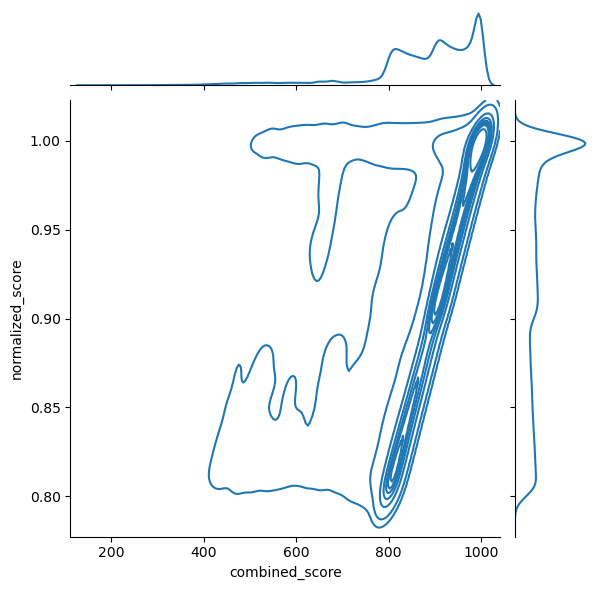

In [94]:
sn.jointplot(gene_net_score_top_x_percent, x="combined_score", y="normalized_score", kind="kde")
plt.savefig("PPI-net/combined-vs-normalized-score-kde-norm-gt-0.8.png", dpi=300)

# Load the filtered PPIs network based on normalized_score and construct network of Genes-of-Interest using Cytoscape. Save the GOIs-PPIs net for further adding formatting and visulaization

In [95]:
df_ensp_prot_goi_net = pd.read_csv(f"PPI-net/GOI-subnet-nd146-edg-390-normscore-gt-0.8.csv", sep=",")

In [96]:
df_ensp_prot_goi_net2 = df_ensp_prot_goi_net.drop(columns=['Color', 'GeneOfInterest','HighConfidence','incoming','selected','TopVariant', 'shared name','MultiVariant']).dropna()
df_ensp_prot_goi_net2

,name,protein_name
10,ENSP00000304235,OR1L6
15,ENSP00000355840,CCDC185
18,ENSP00000334474,ZMIZ1
25,ENSP00000371116,NUTM2D
33,ENSP00000072869,ADCK2
37,ENSP00000272839,METTL21A
54,ENSP00000248594,PTPN12
63,ENSP00000329995,FAM186A
82,ENSP00000330904,OR2T34
83,ENSP00000359505,SDHAF4


In [97]:
df_ensp_prot_goi_net
gene_prot_map = gp.convert(list(df_ensp_prot_goi_net['name'].unique()), target_namespace='ENSP')

In [98]:
epspid_to_name = {a:b for a, b in gene_prot_map[['converted', 'name']].values if a != "None"}

In [99]:
#epspid_to_name

In [100]:
df_ensp_prot_goi_net.Color.fillna('gray')

0      gray
1      gray
2      gray
3      gray
4      gray
       ... 
141    gray
142    gray
143    gray
144    gray
145    gray
Name: Color, Length: 146, dtype: object

In [101]:
df_ensp_prot_goi_net.fillna('N', inplace=True)

In [102]:
df_ensp_prot_goi_net

,Color,GeneOfInterest,HighConfidence,incoming,MultiVariant,name,protein_name,selected,shared name,TopVariant
0,N,N,N,N,N,ENSP00000362680,N,False,ENSP00000362680,N
1,N,N,N,N,N,ENSP00000403459,N,False,ENSP00000403459,N
2,N,N,N,N,N,ENSP00000287078,N,False,ENSP00000287078,N
3,N,N,N,N,N,ENSP00000330862,N,False,ENSP00000330862,N
4,N,N,N,N,N,ENSP00000411960,N,False,ENSP00000411960,N
...,...,...,...,...,...,...,...,...,...,...
141,N,N,N,N,N,ENSP00000301761,N,False,ENSP00000301761,N
142,N,N,N,N,N,ENSP00000220003,N,False,ENSP00000220003,N
143,N,N,N,N,N,ENSP00000281146,N,False,ENSP00000281146,N
144,N,N,N,N,N,ENSP00000443130,N,False,ENSP00000443130,N


In [103]:
for ir, row in df_ensp_prot_goi_net.iterrows():
    name = row['name']
    protein_name = row['protein_name']
    new_prot = epspid_to_name.get(name, '')
    if protein_name == "N":
        df_ensp_prot_goi_net.loc[ir, 'protein_name'] = new_prot

In [104]:
df_ensp_prot_goi_net

,Color,GeneOfInterest,HighConfidence,incoming,MultiVariant,name,protein_name,selected,shared name,TopVariant
0,N,N,N,N,N,ENSP00000362680,SRC,False,ENSP00000362680,N
1,N,N,N,N,N,ENSP00000403459,GRB7,False,ENSP00000403459,N
2,N,N,N,N,N,ENSP00000287078,TYSND1,False,ENSP00000287078,N
3,N,N,N,N,N,ENSP00000330862,OPCML,False,ENSP00000330862,N
4,N,N,N,N,N,ENSP00000411960,HSD17B4,False,ENSP00000411960,N
...,...,...,...,...,...,...,...,...,...,...
141,N,N,N,N,N,ENSP00000301761,SDHAF2,False,ENSP00000301761,N
142,N,N,N,N,N,ENSP00000220003,CSK,False,ENSP00000220003,N
143,N,N,N,N,N,ENSP00000281146,C4orf33,False,ENSP00000281146,N
144,N,N,N,N,N,ENSP00000443130,None,False,ENSP00000443130,N


In [105]:
df_ensp_prot_goi_net.to_csv(f"PPI-net/ENSP-to-protname-goi-subnet-with-goi-annot.csv", sep="\t", index=False)

In [106]:
df_goi_ppis_net = pd.read_csv("PPI-net/GOI-subnet-nd146-edg-390-combined-norm-score-gt-0.8.csv")

In [107]:
df_goi_ppis_net

,combined_score,interaction,name,normalized_score,selected,shared interaction,shared name
0,964,interacts with,ENSP00000267257 (interacts with) ENSP00000376345,0.964965,False,interacts with,ENSP00000267257 (interacts with) ENSP00000376345
1,998,interacts with,ENSP00000368767 (interacts with) ENSP00000355533,0.998999,False,interacts with,ENSP00000368767 (interacts with) ENSP00000355533
2,998,interacts with,ENSP00000368767 (interacts with) ENSP00000261448,0.998999,False,interacts with,ENSP00000368767 (interacts with) ENSP00000261448
3,946,interacts with,ENSP00000352608 (interacts with) ENSP00000499797,0.946947,False,interacts with,ENSP00000352608 (interacts with) ENSP00000499797
4,999,interacts with,ENSP00000355533 (interacts with) ENSP00000291295,1.000000,False,interacts with,ENSP00000355533 (interacts with) ENSP00000291295
...,...,...,...,...,...,...,...
385,953,interacts with,ENSP00000368767 (interacts with) ENSP00000352608,0.953954,False,interacts with,ENSP00000368767 (interacts with) ENSP00000352608
386,999,interacts with,ENSP00000352608 (interacts with) ENSP00000369689,1.000000,False,interacts with,ENSP00000352608 (interacts with) ENSP00000369689
387,542,interacts with,ENSP00000367658 (interacts with) ENSP00000330904,0.936097,False,interacts with,ENSP00000367658 (interacts with) ENSP00000330904
388,999,interacts with,ENSP00000267257 (interacts with) ENSP00000380638,1.000000,False,interacts with,ENSP00000267257 (interacts with) ENSP00000380638


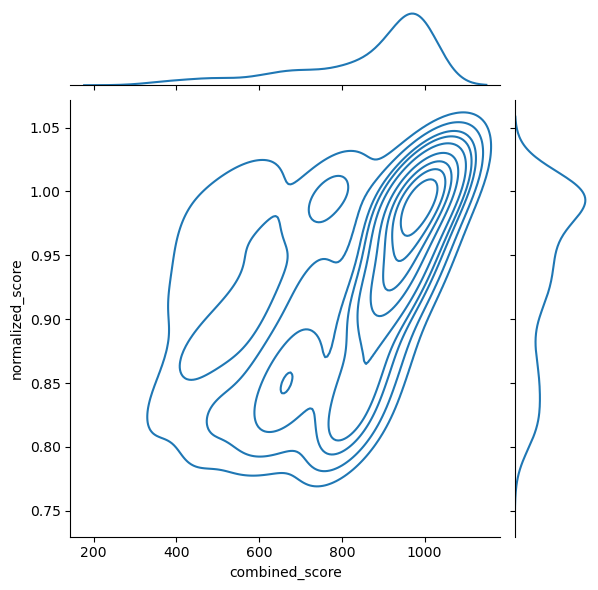

In [108]:
sn.jointplot(df_goi_ppis_net, x="combined_score", y="normalized_score", kind="kde")
plt.savefig("PPI-net/hist-combined_score-nrom-gt0.8-goi-subnet-kde.png", dpi=300)

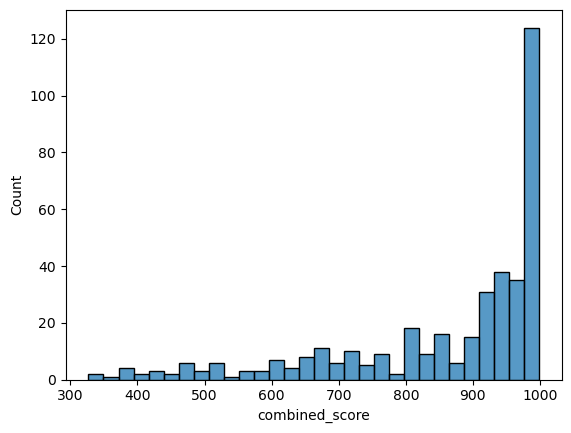

In [109]:
sn.histplot(df_goi_ppis_net, x="combined_score", bins=30)
plt.savefig("PPI-net/hist-combined_score-nrom-gt0.8-goi-subnet.png", dpi=300)